In [4]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import torch

In [5]:
train_data = "data/train.csv"
test_data = "data/test.csv"

train = pd.read_csv(train_data)
test = pd.read_csv(test_data)

In [6]:
Y_data = np.array(train["label"])
X_data = np.array(train.loc[:,"pixel0":]).reshape(-1,1,28,28)/255
print("X_data shape:", X_data.shape)
print("Y_data shape:", Y_data.shape)

X_data shape: (42000, 1, 28, 28)
Y_data shape: (42000,)


In [7]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.from_numpy(X_data).float()
tensor_y = torch.from_numpy(Y_data)

my_dataset = TensorDataset(tensor_x,tensor_y)
train_dataset, val_dataset = torch.utils.data.random_split(my_dataset, (int(len(X_data)*0.99),int(len(X_data)*0.01)))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [8]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
                            nn.Conv2d(1, 32, kernel_size=2), # in_channels,out_channels, kernel_size, stride, padding
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3),
                            nn.Conv2d(32, 64, kernel_size=2), # in_channels,out_channels, kernel_size, stride, padding
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(64, 128, kernel_size=2), # don't have to set padding, PyTorch can handle it.
                            nn.ReLU(),
                            nn.AdaptiveAvgPool2d((6, 6)))
        self.classifier = nn.Sequential(
                            nn.Linear(128*6*6, 1024),
                            nn.Dropout(p=0.2),
                            nn.ReLU(),
                            nn.Linear(1024, 256),
                            nn.Dropout(p=0.1),
                            nn.ReLU(),
                            nn.Linear(256, 10))
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()   # training mode
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()   # evaluation mode for test.
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [10]:
from torch import optim

cnn = CNN()
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")
else:
    device = torch.device("cpu")
    print("cpu")
cnn.to(device)

cuda


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [11]:
optimizer = optim.Adam(cnn.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
train(cnn, optimizer, loss_fn, train_loader=train_loader, val_loader=val_loader, device=device)

Epoch: 0, Training Loss: 0.25, Validation Loss: 0.10, accuracy = 0.96
Epoch: 1, Training Loss: 0.07, Validation Loss: 0.08, accuracy = 0.96
Epoch: 2, Training Loss: 0.05, Validation Loss: 0.04, accuracy = 0.99
Epoch: 3, Training Loss: 0.04, Validation Loss: 0.03, accuracy = 0.99
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.07, accuracy = 0.98
Epoch: 5, Training Loss: 0.03, Validation Loss: 0.03, accuracy = 0.99
Epoch: 6, Training Loss: 0.03, Validation Loss: 0.03, accuracy = 0.99
Epoch: 7, Training Loss: 0.03, Validation Loss: 0.05, accuracy = 0.98
Epoch: 8, Training Loss: 0.02, Validation Loss: 0.03, accuracy = 0.99
Epoch: 9, Training Loss: 0.02, Validation Loss: 0.05, accuracy = 0.98
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.03, accuracy = 0.99
Epoch: 11, Training Loss: 0.02, Validation Loss: 0.03, accuracy = 0.99
Epoch: 12, Training Loss: 0.02, Validation Loss: 0.02, accuracy = 0.99
Epoch: 13, Training Loss: 0.02, Validation Loss: 0.02, accuracy = 0.99
Epoch: 14, Train

In [15]:
test_data = pd.read_csv("data/test.csv")
X_test = np.array(test_data).reshape(-1,1,28,28)/255
print("X_test shape:", X_test.shape)

X_test shape: (28000, 1, 28, 28)


In [16]:
tensor_test = torch.from_numpy(X_test).float()
tensor_test = tensor_test.to(device)

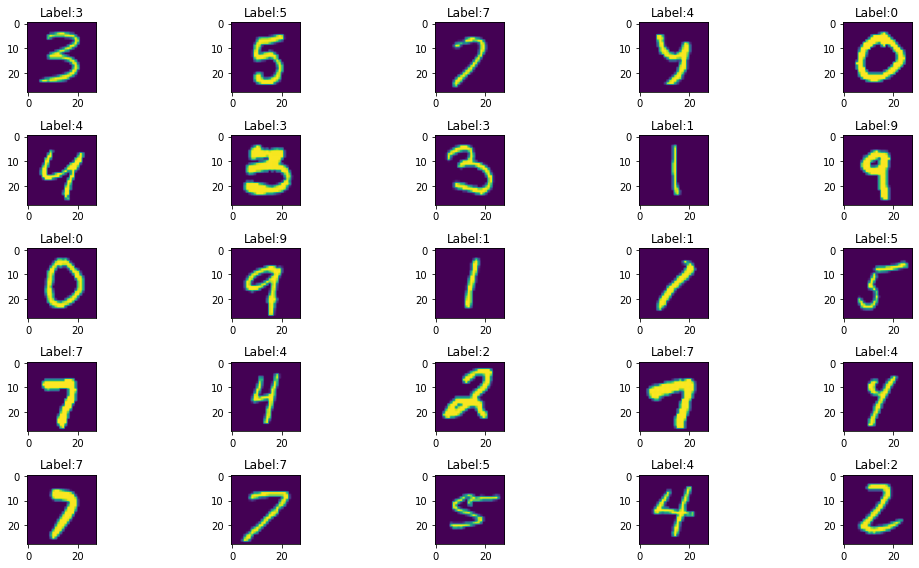

In [33]:
rows = 5
cols = 5
axes=[]
fig=plt.figure(figsize=(15,8))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Label:" + str(torch.argmax(cnn(tensor_test[9+a].reshape(1,1,28,28))).item()))
    axes[-1].set_title(subplot_title)  
    plt.imshow(np.array(tensor_test[9+a].cpu()).reshape(28,28))
fig.tight_layout()    
plt.show()

In [35]:
def predict_test(data, model):
    data = data / 255.0
    data = data.values.reshape(-1,28,28,1)
    return(model.predict(data))

res = predict_test(test, cnn)

AttributeError: 'CNN' object has no attribute 'predict'

In [ ]:
final_result = []
for i in range(len(res)):
    final_result.append(np.argmax(res[i]))
sub['Label'] = final_result

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("logisticregression_withgrid_digits_data.csv",index=False)